<a href="https://colab.research.google.com/github/WizMizTina/Data_Science-and-Machine_Learning/blob/main/Adversarial_Training_Technique_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [ ]:
%matplotlib inline
%tensorflow_version 1.x
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math

TensorFlow 1.x selected.


This was developed using Python 3.6 (Anaconda) and TensorFlow version:

In [ ]:
tf.__version__

'1.15.2'

In [ ]:
# Clone the repository from GitHub to Google Colab's temporary drive.
import os
work_dir = "/content/TensorFlow-Tutorials/"
if not os.path.exists(work_dir):
    !git clone https://github.com/Hvass-Labs/TensorFlow-Tutorials.git
os.chdir(work_dir)

Cloning into 'TensorFlow-Tutorials'...
remote: Enumerating objects: 506, done.
remote: Total 506 (delta 0), reused 0 (delta 0), pack-reused 506
Receiving objects: 100% (506/506), 66.10 MiB | 17.05 MiB/s, done.
Resolving deltas: 100% (241/241), done.


In [ ]:
!pip install -r requirements.txt

  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=75c3e6ed76fc1e5aa134431a4b1d4f054f2034f6a936a9971df1a146b40e0bb1
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Uninstalling gast-0.5.3:
      Successfully uninstalled gast-0.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
kapre 0.3.7 requires tensorflow>=2.0.0, but you have tensorflow 1.15.2 which is incompatible.


## Load Data

The MNIST data-set is about 12 MB and will be downloaded automatically if it is not located in the given path.

In [ ]:
from mnist import MNIST
data = MNIST("data/MNIST/")

- Download progress: 100.0% Done!
- Download progress: 100.0% Done!
- Download progress: 100.0% Done!
- Download progress: 100.0% Done!


The MNIST data-set has now been loaded and consists of 70.000 images and class-numbers for the images. The data-set is split into 3 mutually exclusive sub-sets. We will only use the training and test-sets in this tutorial.

In [ ]:
print("Size of:")
print("- Training-set:\t\t{}".format(data.num_train))
print("- Validation-set:\t{}".format(data.num_val))
print("- Test-set:\t\t{}".format(data.num_test))

Size of:
- Training-set:		55000
- Validation-set:	5000
- Test-set:		10000


Copy some of the data-dimensions for convenience.

In [ ]:
# The number of pixels in each dimension of an image.
img_size = data.img_size

# The images are stored in one-dimensional arrays of this length.
img_size_flat = data.img_size_flat

# Tuple with height and width of images used to reshape arrays.
img_shape = data.img_shape

# Number of classes, one class for each of 10 digits.
num_classes = data.num_classes

# Number of colour channels for the images: 1 channel for gray-scale.
num_channels = data.num_channels

### Helper-function for plotting images

Function used to plot 9 images in a 3x3 grid, and writing the true and predicted classes below each image. If the noise is supplied then it is added to all images.

In [ ]:
def plot_images(images, cls_true, cls_pred=None, noise=0.0):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 4x4 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Get the i'th image and reshape the array.
        image = images[i].reshape(img_shape)
        
        # Add the adversarial noise to the image.
        image += noise
        
        # Ensure the noisy pixel-values are between 0 and 1.
        image = np.clip(image, 0.0, 1.0)

        # Plot image.
        ax.imshow(image,
                  cmap='binary', interpolation='nearest')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### Plot a few images to see if data is correct

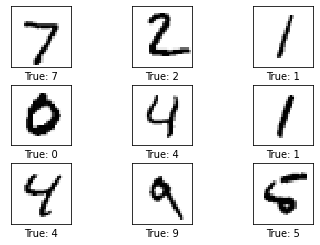

In [ ]:
# Get the first images from the test-set.
images = data.x_test[0:9]

# Get the true classes for those images.
cls_true = data.y_test_cls[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)

## TensorFlow Graph

The computational graph for the neural network will now be constructed using TensorFlow and PrettyTensor. As usual, we need to create placeholder variables for feeding images into the graph and then we add the adversarial noise to the images. The noisy images are then used as input to a convolutional neural network.

There are two separate optimization procedures for this network. A normal optimization procedure for the variables of the neural network itself, and another optimization procedure for the adversarial noise. Both optimization procedures are implemented directly in TensorFlow.

### Placeholder variables

Placeholder variables provide the input to the computational graph in TensorFlow that we may change each time we execute the graph. We call this feeding the placeholder variables.

First we define the placeholder variable for the input images. This allows us to change the images that are input to the TensorFlow graph. This is a so-called tensor, which just means that it is a multi-dimensional array. The data-type is set to `float32` and the shape is set to `[None, img_size_flat]`, where `None` means that the tensor may hold an arbitrary number of images with each image being a vector of length `img_size_flat`.

In [ ]:
x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x')

The convolutional layers expect `x` to be encoded as a 4-dim tensor so we have to reshape it so its shape is instead `[num_images, img_height, img_width, num_channels]`. Note that `img_height == img_width == img_size` and `num_images` can be inferred automatically by using -1 for the size of the first dimension. So the reshape operation is:

In [ ]:
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])

Next we have the placeholder variable for the true labels associated with the images that were input in the placeholder variable `x`. The shape of this placeholder variable is `[None, num_classes]` which means it may hold an arbitrary number of labels and each label is a vector of length `num_classes` which is 10 in this case.

In [ ]:
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')

We could also have a placeholder variable for the class-number, but we will instead calculate it using argmax. Note that this is a TensorFlow operator so nothing is calculated at this point.

In [ ]:
y_true_cls = tf.argmax(y_true, axis=1)

### Adversarial Noise

The pixels in the input image are float-values between 0.0 and 1.0. The adversarial noise is a number that is added or subtracted from the pixels in the input image.

The limit of the adversarial noise is set to 0.35 so the noise will be between &plusmn;0.35.

In [ ]:
noise_limit = 0.35

The optimizer for the adversarial noise will try and minimize two loss-measures: (1) The normal loss-measure for the neural network, so we will find the noise that gives the best classification accuracy for the adversarial target-class; and (2) the so-called L2-loss-measure which tries to keep the noise as low as possible.

The following weight determines how important the L2-loss is compared to the normal loss-measure. An L2-weight close to zero usually works best.

In [ ]:
noise_l2_weight = 0.02

When we create the new variable for the noise, we must inform TensorFlow which variable-collections that it belongs to, so we can later inform the two optimizers which variables to update.

First we define a name for our new variable-collection. This is just a string.

In [ ]:
ADVERSARY_VARIABLES = 'adversary_variables'

Then we create a list of the collections that we want the new noise-variable to belong to. If we add the noise-variable to the collection `tf.GraphKeys.VARIABLES` then it will also get initialized with all the other variables in the TensorFlow graph, but it will not get optimized. This is a bit confusing.

In [ ]:
collections = [tf.GraphKeys.GLOBAL_VARIABLES, ADVERSARY_VARIABLES]

Now we can create the new variable for the adversarial noise. It will be initialized to zero. It will not be trainable, so it will not be optimized along with the other variables of the neural network. This allows us to create two separate optimization procedures.

In [ ]:
x_noise = tf.Variable(tf.zeros([img_size, img_size, num_channels]),
                      name='x_noise', trainable=False,
                      collections=collections)

The adversarial noise will be limited / clipped to the given 
&plusmn; noise-limit that we set above. Note that this is actually not executed at this point in the computational graph, but will instead be executed after the optimization-step, see further below.

In [ ]:
x_noise_clip = tf.assign(x_noise, tf.clip_by_value(x_noise,
                                                   -noise_limit,
                                                   noise_limit))

The noisy image is just the sum of the input image and the adversarial noise.

In [ ]:
x_noisy_image = x_image + x_noise

When adding the noise to the input image, it may overflow the boundaries for a valid image, so we clip / limit the noisy image to ensure its pixel-values are between 0 and 1.

In [ ]:
x_noisy_image = tf.clip_by_value(x_noisy_image, 0.0, 1.0)

### Convolutional Neural Network

We will use the Layers API to construct the convolutional neural network, but this time we have 11 neural networks.

In [ ]:
# Start the network with the noisy input image.

net = x_noisy_image

net = tf.layers.flatten(net)

# 1st fully-connected / dense layer.
net = tf.layers.dense(inputs=net, name='layer_fc',
                      units=128, activation=tf.nn.relu)
net = tf.layers.dense(inputs=net, name='layer_fcc',
                      units=64, activation=tf.nn.relu)

# 2nd fully-connected / dense layer.
net = tf.layers.dense(inputs=net, name='layer_fc_out',
                      units=num_classes, activation=None)

# Unscaled output of the network.
logits = net

# Softmax output of the network.
y_pred = tf.nn.softmax(logits=logits)

# Loss measure to be optimized.
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_true,
                                                           logits=logits)
loss = tf.reduce_mean(cross_entropy)
#create more nueral networks

Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.Dense instead.


In [ ]:
# Start the network with the noisy input image.

net0 = x_noisy_image

net0 = tf.layers.flatten(net0)

# 1st fully-connected / dense layer.
net0 = tf.layers.dense(inputs=net0, name='layer_fc0',
                      units=128, activation=tf.nn.relu)
net0 = tf.layers.dense(inputs=net0, name='layer_fc_0',
                      units=64, activation=tf.nn.relu)

# 2nd fully-connected / dense layer.
net0 = tf.layers.dense(inputs=net0, name='layer_fc_out_0',
                      units=num_classes, activation=None)

# Unscaled output of the network.
logits = net0

# Softmax output of the network.
y_pred_0 = tf.nn.softmax(logits=logits)

# Loss measure to be optimized.
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_true,
                                                           logits=logits)
loss_0 = tf.reduce_mean(cross_entropy)
#create more nueral networks

In [ ]:
# Start the network with the noisy input image.
net1 = x_noisy_image

# 1st convolutional layer.


net1 = tf.layers.flatten(net1)

# 1st fully-connected / dense layer.
net1 = tf.layers.dense(inputs=net1, name='layer_fc1',
                      units=128, activation=tf.nn.relu)
net1 = tf.layers.dense(inputs=net1, name='layer_fc_1',
                      units=64, activation=tf.nn.relu)

# 2nd fully-connected / dense layer.
net1 = tf.layers.dense(inputs=net1, name='layer_fc_out1',
                      units=num_classes, activation=None)

# Unscaled output of the network.
logits = net1

# Softmax output of the network.
y_pred_1 = tf.nn.softmax(logits=logits)

# Loss measure to be optimized.
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_true,
                                                           logits=logits)
loss_1 = tf.reduce_mean(cross_entropy)
#create more nueral networks

In [ ]:
# Start the network with the noisy input image.
net2 = x_noisy_image

net2 = tf.layers.flatten(net2)

# 1st fully-connected / dense layer.
net2 = tf.layers.dense(inputs=net2, name='layer_fc2',
                      units=128, activation=tf.nn.relu)
net2 = tf.layers.dense(inputs=net2, name='layer_fc_2',
                      units=64, activation=tf.nn.relu)

# 2nd fully-connected / dense layer.
net2 = tf.layers.dense(inputs=net2, name='layer_fc_out2',
                      units=num_classes, activation=None)

# Unscaled output of the network.
logits = net2

# Softmax output of the network.
y_pred_2 = tf.nn.softmax(logits=logits)

# Loss measure to be optimized.
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_true,
                                                           logits=logits)
loss_2 = tf.reduce_mean(cross_entropy)
#create more nueral networks

In [ ]:
# Start the network with the noisy input image.
net3 = x_noisy_image

net3 = tf.layers.flatten(net3)

# 1st fully-connected / dense layer.
net3 = tf.layers.dense(inputs=net3, name='layer_fc3',
                      units=128, activation=tf.nn.relu)
net3 = tf.layers.dense(inputs=net3, name='layer_fc_3',
                      units=64, activation=tf.nn.relu)

# 2nd fully-connected / dense layer.
net3 = tf.layers.dense(inputs=net3, name='layer_fc_out3',
                      units=num_classes, activation=None)

# Unscaled output of the network.
logits = net3

# Softmax output of the network.
y_pred_3 = tf.nn.softmax(logits=logits)

# Loss measure to be optimized.
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_true,
                                                           logits=logits)
loss_3 = tf.reduce_mean(cross_entropy)
#create more nueral networks

In [ ]:
# Start the network with the noisy input image.
net4 = x_noisy_image

net4 = tf.layers.flatten(net4)

# 1st fully-connected / dense layer.
net4 = tf.layers.dense(inputs=net4, name='layer_fc4',
                      units=128, activation=tf.nn.relu)
net4 = tf.layers.dense(inputs=net4, name='layer_fc_4',
                      units=64, activation=tf.nn.relu)

# 2nd fully-connected / dense layer.
net4 = tf.layers.dense(inputs=net4, name='layer_fc_out4',
                      units=num_classes, activation=None)


# Unscaled output of the network.
logits = net4

# Softmax output of the network.
y_pred_4 = tf.nn.softmax(logits=logits)

# Loss measure to be optimized.
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_true,
                                                           logits=logits)
loss_4 = tf.reduce_mean(cross_entropy)
#create more nueral networks

In [ ]:
# Start the network with the noisy input image.
net5 = x_noisy_image

net5 = tf.layers.flatten(net5)

# 1st fully-connected / dense layer.
net5 = tf.layers.dense(inputs=net5, name='layer_fc5',
                      units=128, activation=tf.nn.relu)
net5 = tf.layers.dense(inputs=net5, name='layer_fc_5',
                      units=64, activation=tf.nn.relu)

# 2nd fully-connected / dense layer.
net5 = tf.layers.dense(inputs=net5, name='layer_fc_out5',
                      units=num_classes, activation=None)

# Unscaled output of the network.
logits = net5

# Softmax output of the network.
y_pred_5 = tf.nn.softmax(logits=logits)

# Loss measure to be optimized.
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_true,
                                                           logits=logits)
loss_5 = tf.reduce_mean(cross_entropy)
#create more nueral networks

In [ ]:
# Start the network with the noisy input image.
net6 = x_noisy_image

net6 = tf.layers.flatten(net6)

# 1st fully-connected / dense layer.
net6 = tf.layers.dense(inputs=net6, name='layer_fc6',
                      units=128, activation=tf.nn.relu)
net6 = tf.layers.dense(inputs=net6, name='layer_fc_6',
                      units=64, activation=tf.nn.relu)

# 2nd fully-connected / dense layer.
net6 = tf.layers.dense(inputs=net6, name='layer_fc_out6',
                      units=num_classes, activation=None)


# Unscaled output of the network.
logits = net6

# Softmax output of the network.
y_pred_6 = tf.nn.softmax(logits=logits)

# Loss measure to be optimized.
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_true,
                                                           logits=logits)
loss_6 = tf.reduce_mean(cross_entropy)
#create more nueral networks

In [ ]:
# Start the network with the noisy input image.
net7 = x_noisy_image

net7 = tf.layers.flatten(net7)

# 1st fully-connected / dense layer.
net7 = tf.layers.dense(inputs=net7, name='layer_fc7',
                      units=128, activation=tf.nn.relu)
net7 = tf.layers.dense(inputs=net7, name='layer_fc_7',
                      units=64, activation=tf.nn.relu)

# 2nd fully-connected / dense layer.
net7 = tf.layers.dense(inputs=net7, name='layer_fc_out7',
                      units=num_classes, activation=None)

# Unscaled output of the network.
logits = net7

# Softmax output of the network.
y_pred_7 = tf.nn.softmax(logits=logits)

# Loss measure to be optimized.
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_true,
                                                           logits=logits)
loss_7 = tf.reduce_mean(cross_entropy)
#create more nueral networks

In [ ]:
# Start the network with the noisy input image.
net8 = x_noisy_image


net8 = tf.layers.flatten(net8)

# 1st fully-connected / dense layer.
net8 = tf.layers.dense(inputs=net8, name='layer_fc8',
                      units=128, activation=tf.nn.relu)
net8 = tf.layers.dense(inputs=net8, name='layer_fc_8',
                      units=64, activation=tf.nn.relu)

# 2nd fully-connected / dense layer.
net8 = tf.layers.dense(inputs=net8, name='layer_fc_out8',
                      units=num_classes, activation=None)

# Unscaled output of the network.
logits = net8

# Softmax output of the network.
y_pred_8 = tf.nn.softmax(logits=logits)

# Loss measure to be optimized.
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_true,
                                                           logits=logits)
loss_8 = tf.reduce_mean(cross_entropy)
#create more nueral networks

In [ ]:
# Start the network with the noisy input image.
net9 = x_noisy_image

net9 = tf.layers.flatten(net9)

# 1st fully-connected / dense layer.
net9 = tf.layers.dense(inputs=net9, name='layer_fc9',
                      units=128, activation=tf.nn.relu)
net9 = tf.layers.dense(inputs=net9, name='layer_fc_9',
                      units=64, activation=tf.nn.relu)

# 2nd fully-connected / dense layer.
net9 = tf.layers.dense(inputs=net9, name='layer_fc_out9',
                      units=num_classes, activation=None)

# Unscaled output of the network.
logits = net9

# Softmax output of the network.
y_pred_9 = tf.nn.softmax(logits=logits)

# Loss measure to be optimized.
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_true,
                                                           logits=logits)
loss_9 = tf.reduce_mean(cross_entropy)
#create more nueral networks

### Optimizer for Normal Training

This is a list of the variables for the neural network that will be trained during the normal optimization procedure. Note that `'x_noise:0'` is not in the list, so the adversarial noise is not being optimized in the normal procedure.

In [ ]:
[var.name for var in tf.trainable_variables()]

['layer_fc/kernel:0',
 'layer_fc/bias:0',
 'layer_fcc/kernel:0',
 'layer_fcc/bias:0',
 'layer_fc_out/kernel:0',
 'layer_fc_out/bias:0',
 'layer_fc0/kernel:0',
 'layer_fc0/bias:0',
 'layer_fc_0/kernel:0',
 'layer_fc_0/bias:0',
 'layer_fc_out_0/kernel:0',
 'layer_fc_out_0/bias:0',
 'layer_fc1/kernel:0',
 'layer_fc1/bias:0',
 'layer_fc_1/kernel:0',
 'layer_fc_1/bias:0',
 'layer_fc_out1/kernel:0',
 'layer_fc_out1/bias:0',
 'layer_fc2/kernel:0',
 'layer_fc2/bias:0',
 'layer_fc_2/kernel:0',
 'layer_fc_2/bias:0',
 'layer_fc_out2/kernel:0',
 'layer_fc_out2/bias:0',
 'layer_fc3/kernel:0',
 'layer_fc3/bias:0',
 'layer_fc_3/kernel:0',
 'layer_fc_3/bias:0',
 'layer_fc_out3/kernel:0',
 'layer_fc_out3/bias:0',
 'layer_fc4/kernel:0',
 'layer_fc4/bias:0',
 'layer_fc_4/kernel:0',
 'layer_fc_4/bias:0',
 'layer_fc_out4/kernel:0',
 'layer_fc_out4/bias:0',
 'layer_fc5/kernel:0',
 'layer_fc5/bias:0',
 'layer_fc_5/kernel:0',
 'layer_fc_5/bias:0',
 'layer_fc_out5/kernel:0',
 'layer_fc_out5/bias:0',
 'layer_fc

Optimization of these variables in the neural network is done with the Adam-optimizer using the loss-measure that was returned from PrettyTensor when we constructed the neural network above.

Note that optimization is not performed at this point. In fact, nothing is calculated at all, we just add the optimizer-object to the TensorFlow graph for later execution.

In [ ]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(loss)
optimizer_0 = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(loss_0)
optimizer_1 = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(loss_1)
optimizer_2 = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(loss_2)
optimizer_3 = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(loss_3)
optimizer_4 = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(loss_4)
optimizer_5 = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(loss_5)
optimizer_6 = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(loss_6)
optimizer_7 = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(loss_7)
optimizer_8 = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(loss_8)
optimizer_9 = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(loss_9)

### Optimizer for Adversarial Noise

Get the list of variables that must be optimized in the second procedure for the adversarial noise.

In [ ]:
adversary_variables = tf.get_collection(ADVERSARY_VARIABLES)

Show the list of variable-names. There is only one, which is the adversarial noise variable that we created above.

In [ ]:
[var.name for var in adversary_variables]

['x_noise:0']

We will combine the loss-function for the normal optimization with a so-called L2-loss for the noise-variable. This should result in the minimum values for the adversarial noise along with the best classification accuracy.

The L2-loss is scaled by a weight that is typically set close to zero.

In [ ]:
l2_loss_noise = noise_l2_weight * tf.nn.l2_loss(x_noise)

Combine the normal loss-function with the L2-loss for the adversarial noise.

In [ ]:
loss_adversary = loss  + l2_loss_noise
loss_adversary0 = loss_0 + l2_loss_noise
loss_adversary1 = loss_1 + l2_loss_noise
loss_adversary2 = loss_2 + l2_loss_noise
loss_adversary3 = loss_3 + l2_loss_noise
loss_adversary4 = loss_4 + l2_loss_noise
loss_adversary5 = loss_5 + l2_loss_noise
loss_adversary6 = loss_6 + l2_loss_noise
loss_adversary7 = loss_7 + l2_loss_noise
loss_adversary8 = loss_8 + l2_loss_noise
loss_adversary9 = loss_9 + l2_loss_noise

We can now create the optimizer for the adversarial noise. Because this optimizer is not supposed to update all the variables of the neural network, we must give it a list of the variables that we want updated, which is the variable for the adversarial noise. Also note the learning-rate is much greater than for the normal optimizer above.

In [ ]:
optimizer_adversary = tf.train.AdamOptimizer(learning_rate=1e-2).minimize(loss_adversary, var_list=adversary_variables)
optimizer_adversary_0 = tf.train.AdamOptimizer(learning_rate=1e-2).minimize(loss_adversary0, var_list=adversary_variables)
optimizer_adversary_1 = tf.train.AdamOptimizer(learning_rate=1e-2).minimize(loss_adversary1, var_list=adversary_variables)
optimizer_adversary_2 = tf.train.AdamOptimizer(learning_rate=1e-2).minimize(loss_adversary2, var_list=adversary_variables)
optimizer_adversary_3 = tf.train.AdamOptimizer(learning_rate=1e-2).minimize(loss_adversary3, var_list=adversary_variables)
optimizer_adversary_4 = tf.train.AdamOptimizer(learning_rate=1e-2).minimize(loss_adversary4, var_list=adversary_variables)
optimizer_adversary_5 = tf.train.AdamOptimizer(learning_rate=1e-2).minimize(loss_adversary5, var_list=adversary_variables)
optimizer_adversary_6 = tf.train.AdamOptimizer(learning_rate=1e-2).minimize(loss_adversary6, var_list=adversary_variables)
optimizer_adversary_7 = tf.train.AdamOptimizer(learning_rate=1e-2).minimize(loss_adversary7, var_list=adversary_variables)
optimizer_adversary_8 = tf.train.AdamOptimizer(learning_rate=1e-2).minimize(loss_adversary8, var_list=adversary_variables)
optimizer_adversary_9 = tf.train.AdamOptimizer(learning_rate=1e-2).minimize(loss_adversary9, var_list=adversary_variables)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


We have now created two optimizers for the neural network, one for the variables of the neural network and another for the single variable with the adversarial noise.

### Performance Measures

We need a few more operations in the TensorFlow graph which will make it easier for us to display the progress to the user during optimization.

First we calculate the predicted class number from the output of the Neural Network `y_pred`, which is a vector with 10 elements. The class number is the index of the largest element.

In [ ]:
y_pred_cls = tf.argmax(y_pred, axis=1)
y_pred_cls_0 = tf.argmax(y_pred_0, axis=1)
y_pred_cls_1 = tf.argmax(y_pred_1, axis=1)
y_pred_cls_2 = tf.argmax(y_pred_2, axis=1)
y_pred_cls_3 = tf.argmax(y_pred_3, axis=1)
y_pred_cls_4 = tf.argmax(y_pred_4, axis=1)
y_pred_cls_5 = tf.argmax(y_pred_5, axis=1)
y_pred_cls_6 = tf.argmax(y_pred_6, axis=1)
y_pred_cls_7 = tf.argmax(y_pred_7, axis=1)
y_pred_cls_8 = tf.argmax(y_pred_8, axis=1)
y_pred_cls_9 = tf.argmax(y_pred_9, axis=1)

Then we create a vector of booleans telling us whether the predicted class equals the true class of each image.

In [ ]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
correct_prediction_0 = tf.equal(y_pred_cls_0, y_true_cls)
correct_prediction_1 = tf.equal(y_pred_cls_1, y_true_cls)
correct_prediction_2 = tf.equal(y_pred_cls_2, y_true_cls)
correct_prediction_3 = tf.equal(y_pred_cls_3, y_true_cls)
correct_prediction_4 = tf.equal(y_pred_cls_4, y_true_cls)
correct_prediction_5 = tf.equal(y_pred_cls_5, y_true_cls)
correct_prediction_6 = tf.equal(y_pred_cls_6, y_true_cls)
correct_prediction_7 = tf.equal(y_pred_cls_7, y_true_cls)
correct_prediction_8 = tf.equal(y_pred_cls_8, y_true_cls)
correct_prediction_9 = tf.equal(y_pred_cls_9, y_true_cls)

The classification accuracy is calculated by first type-casting the vector of booleans to floats, so that False becomes 0 and True becomes 1, and then taking the average of these numbers.

In [ ]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
accuracy_0 = tf.reduce_mean(tf.cast(correct_prediction_0, tf.float32))
accuracy_1 = tf.reduce_mean(tf.cast(correct_prediction_1, tf.float32))
accuracy_2 = tf.reduce_mean(tf.cast(correct_prediction_2, tf.float32))
accuracy_3 = tf.reduce_mean(tf.cast(correct_prediction_3, tf.float32))
accuracy_4 = tf.reduce_mean(tf.cast(correct_prediction_4, tf.float32))
accuracy_5 = tf.reduce_mean(tf.cast(correct_prediction_5, tf.float32))
accuracy_6 = tf.reduce_mean(tf.cast(correct_prediction_6, tf.float32))
accuracy_7 = tf.reduce_mean(tf.cast(correct_prediction_7, tf.float32))
accuracy_8 = tf.reduce_mean(tf.cast(correct_prediction_8, tf.float32))
accuracy_9 = tf.reduce_mean(tf.cast(correct_prediction_9, tf.float32))

## TensorFlow Run

### Create TensorFlow session

Once the TensorFlow graph has been created, we have to create a TensorFlow session which is used to execute the graph.

In [ ]:
session = tf.Session()

### Initialize variables

The variables for `weights` and `biases` must be initialized before we start optimizing them.

In [ ]:
session.run(tf.global_variables_initializer())

This is a helper-function for initializing / resetting the adversarial noise to zero.

In [ ]:
def init_noise():
    session.run(tf.variables_initializer([x_noise]))

Call the function to initialize the adversarial noise.

In [ ]:
init_noise()

### Helper-function to perform optimization iterations

There are 55,000 images in the training-set. It takes a long time to calculate the gradient of the model using all these images. We therefore only use a small batch of images in each iteration of the optimizer.

In [ ]:
train_batch_size = 300

Below is the function for performing a number of optimization iterations so as to gradually improve the variables of the neural network. In each iteration, a new batch of data is selected from the training-set and then TensorFlow executes the optimizer using those training samples. The progress is printed every 100 iterations.

When the target-class is set to an integer, it will be used instead of the true class-number for the training-data. The adversarial optimizer is also used instead of the normal optimizer, and after each step of the adversarial optimizer, the noise will be limited / clipped to the allowed range. This optimizes the adversarial noise and ignores the other variables of the neural network.

In [ ]:
def optimize_f(accuracy,num_iterations,optimizer,optimizer_adversary, adversary_target_cls=None):
    # Start-time used for printing time-usage below.
    start_time = time.time()

    for i in range(num_iterations):

        # Get a batch of training examples.
        # x_batch now holds a batch of images and
        # y_true_batch are the true labels for those images.
        x_batch, y_true_batch, _ = data.random_batch(batch_size=train_batch_size)

        # If we are searching for the adversarial noise, then
        # use the adversarial target-class instead.
        
        if adversary_target_cls is not None:
            # The class-labels are One-Hot encoded.
            
            # Set all the class-labels to zero.
            y_true_batch = np.zeros_like(y_true_batch)

            # Set the element for the adversarial target-class to 1.
            y_true_batch[:, adversary_target_cls] = 1.0
            
        # Put the batch into a dict with the proper names
        # for placeholder variables in the TensorFlow graph.
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}


        # If doing normal optimization of the neural network.
        if adversary_target_cls is None:
            # Run the optimizer using this batch of training data.
            # TensorFlow assigns the variables in feed_dict_train
            # to the placeholder variables and then runs the optimizer.
            session.run(optimizer, feed_dict=feed_dict_train)
        else:
            #change here
            # Run the adversarial optimizer instead.
            # Note that we have 'faked' the class above to be
            # the adversarial target-class instead of the true class.
            session.run(optimizer_adversary, feed_dict=feed_dict_train)
            
            # Clip / limit the adversarial noise. This executes
            # another TensorFlow operation. It cannot be executed
            # in the same session.run() as the optimizer, because
            # it may run in parallel so the execution order is not
            # guaranteed. We need the clip to run after the optimizer.
            session.run(x_noise_clip)

        # Print status every 100 iterations.
        if (i % 100 == 0) or (i == num_iterations - 1):
            # Calculate the accuracy on the training-set.
            acc = session.run(accuracy, feed_dict=feed_dict_train)

            # Message for printing.
            msg = "Optimization Iteration: {0:>6}, Training Accuracy: {1:>6.1%}"

            # Print it.
            print(msg.format(i, acc))

    # Ending time.
    end_time = time.time()

    # Difference between start and end-times.
    time_dif = end_time - start_time

    # Print the time-usage.
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

### Helper-functions for getting and plotting the noise

This function gets the adversarial noise from inside the TensorFlow graph.

In [ ]:
def get_noise():
    # Run the TensorFlow session to retrieve the contents of
    # the x_noise variable inside the graph.
    noise = session.run(x_noise)

    return np.squeeze(noise)

This function plots the adversarial noise and prints some statistics.

In [ ]:
def plot_noise():
    # Get the adversarial noise from inside the TensorFlow graph.
    noise = get_noise()
    
    # Print statistics.
    print("Noise:")
    print("- Min:", noise.min())
    print("- Max:", noise.max())
    print("- Std:", noise.std())

    # Plot the noise.
    plt.imshow(noise, interpolation='nearest', cmap='seismic',
               vmin=-1.0, vmax=1.0)

### Helper-function to plot example errors

Function for plotting examples of images from the test-set that have been mis-classified.

In [ ]:
def plot_example_errors(cls_pred, correct):
    # This function is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # correct is a boolean array whether the predicted class
    # is equal to the true class for each image in the test-set.

    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = data.x_test[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = data.y_test_cls[incorrect]

    # Get the adversarial noise from inside the TensorFlow graph.
    noise = get_noise()
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9],
                noise=noise)

### Helper-function to plot confusion matrix

In [ ]:
def plot_confusion_matrix(cls_pred):
    # This is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Get the true classifications for the test-set.
    cls_true = data.y_test_cls
    
    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)

    # Print the confusion matrix as text.
    print(cm)

### Helper-function for showing the performance

Function for printing the classification accuracy on the test-set.

It takes a while to compute the classification for all the images in the test-set, that's why the results are re-used by calling the above functions directly from this function, so the classifications don't have to be recalculated by each function.


In [ ]:
# Split the test-set into smaller batches of this size.
test_batch_size = 256

def print_test_accuracy(y_pred_cls,show_example_errors=False,
                        show_confusion_matrix=False):

    # Number of images in the test-set.
    num_test = data.num_test

    # Allocate an array for the predicted classes which
    # will be calculated in batches and filled into this array.
    cls_pred = np.zeros(shape=num_test, dtype=np.int)

    # Now calculate the predicted classes for the batches.
    # We will just iterate through all the batches.
    # There might be a more clever and Pythonic way of doing this.

    # The starting index for the next batch is denoted i.
    i = 0

    while i < num_test:
        # The ending index for the next batch is denoted j.
        j = min(i + test_batch_size, num_test)

        # Get the images from the test-set between index i and j.
        images = data.x_test[i:j, :]

        # Get the associated labels.
        labels = data.y_test[i:j, :]

        # Create a feed-dict with these images and labels.
        feed_dict = {x: images,
                     y_true: labels}

        # Calculate the predicted class using TensorFlow.
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)

        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j

    # Convenience variable for the true class-numbers of the test-set.
    cls_true = data.y_test_cls

    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)

    # Calculate the number of correctly classified images.
    # When summing a boolean array, False means 0 and True means 1.
    correct_sum = correct.sum()

    # Classification accuracy is the number of correctly classified
    # images divided by the total number of images in the test-set.
    acc = float(correct_sum) / num_test

    # Print the accuracy.
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))

    # Plot some examples of mis-classifications, if desired.
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    # Plot the confusion matrix, if desired.
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

Lists with the variables for each of our 10 neural networks in the second tier

In [ ]:
opt_list = [optimizer_0,optimizer_1,optimizer_2,optimizer_3,optimizer_4,optimizer_5,optimizer_6,optimizer_7,optimizer_8,optimizer_9]
opt_adv_list = [optimizer_adversary_0,optimizer_adversary_1,optimizer_adversary_2,optimizer_adversary_3,optimizer_adversary_4,optimizer_adversary_5,optimizer_adversary_6,optimizer_adversary_7,optimizer_adversary_8,optimizer_adversary_9]
acc_list = [accuracy_0,accuracy_1,accuracy_2,accuracy_3,accuracy_4,accuracy_5,accuracy_6,accuracy_7,accuracy_8,accuracy_9]
test_acc_list = [y_pred_cls_0,y_pred_cls_1,y_pred_cls_2,y_pred_cls_3,y_pred_cls_4,y_pred_cls_5,y_pred_cls_6,y_pred_cls_7,y_pred_cls_8,y_pred_cls_9]

## Normal optimization of neural network

First we perform 1000 optimization iterations with the normal optimizer. This finds the variables that makes the neural network perform well on the training-set.

The adversarial noise is not effective yet because it has only been initialized to zero above and it is not being updated during this optimization.

In [ ]:
optimize_f(optimizer=optimizer,accuracy=accuracy,optimizer_adversary = None, num_iterations=800)

Optimization Iteration:      0, Training Accuracy:  15.3%
Optimization Iteration:    100, Training Accuracy:  95.7%
Optimization Iteration:    200, Training Accuracy:  92.7%
Optimization Iteration:    300, Training Accuracy:  94.3%
Optimization Iteration:    400, Training Accuracy:  93.3%
Optimization Iteration:    500, Training Accuracy:  96.7%
Optimization Iteration:    600, Training Accuracy:  97.0%
Optimization Iteration:    700, Training Accuracy:  99.7%
Optimization Iteration:    799, Training Accuracy:  98.3%
Time usage: 0:00:09


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if sys.path[0] == '':


Accuracy on Test-Set: 96.9% (9694 / 10000)
Example errors:


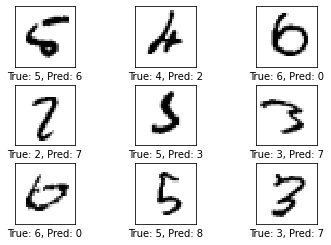

In [ ]:
print_test_accuracy(y_pred_cls,show_example_errors=True)

In [ ]:
for i in range(10):
  optimize_f(optimizer=opt_list[i],accuracy=acc_list[i],optimizer_adversary = None, num_iterations=800)

Optimization Iteration:      0, Training Accuracy:  16.0%
Optimization Iteration:    100, Training Accuracy:  92.0%
Optimization Iteration:    200, Training Accuracy:  96.0%
Optimization Iteration:    300, Training Accuracy:  91.3%
Optimization Iteration:    400, Training Accuracy:  96.3%
Optimization Iteration:    500, Training Accuracy:  97.0%
Optimization Iteration:    600, Training Accuracy:  96.3%
Optimization Iteration:    700, Training Accuracy:  96.3%
Optimization Iteration:    799, Training Accuracy:  97.7%
Time usage: 0:00:08
Optimization Iteration:      0, Training Accuracy:  21.7%
Optimization Iteration:    100, Training Accuracy:  89.0%
Optimization Iteration:    200, Training Accuracy:  94.0%
Optimization Iteration:    300, Training Accuracy:  96.7%
Optimization Iteration:    400, Training Accuracy:  95.3%
Optimization Iteration:    500, Training Accuracy:  97.7%
Optimization Iteration:    600, Training Accuracy:  97.3%
Optimization Iteration:    700, Training Accuracy:  

The classification accuracy is now about 96-97% on the test-set. (This will vary each time you run this Python Notebook).

Accuracy on Test-Set: 96.9% (9687 / 10000)
Example errors:


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if sys.path[0] == '':


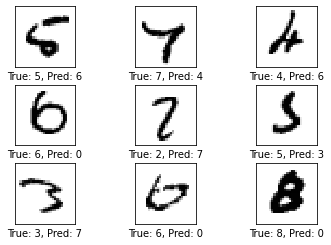

Accuracy on Test-Set: 96.4% (9643 / 10000)
Example errors:


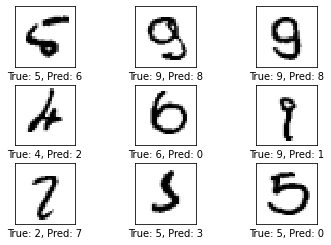

Accuracy on Test-Set: 97.0% (9701 / 10000)
Example errors:


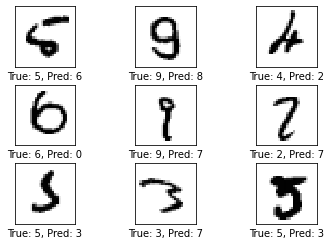

Accuracy on Test-Set: 97.0% (9698 / 10000)
Example errors:


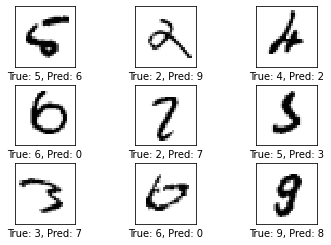

Accuracy on Test-Set: 96.5% (9647 / 10000)
Example errors:


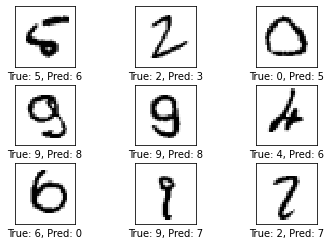

Accuracy on Test-Set: 96.9% (9691 / 10000)
Example errors:


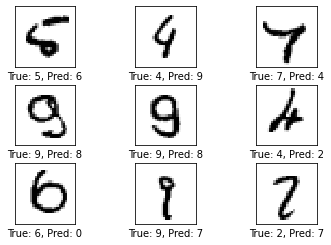

Accuracy on Test-Set: 97.1% (9707 / 10000)
Example errors:


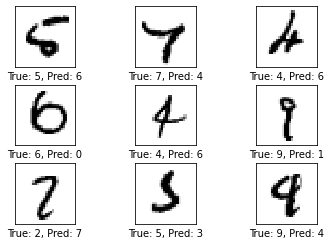

Accuracy on Test-Set: 96.7% (9669 / 10000)
Example errors:


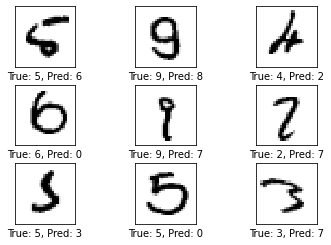

Accuracy on Test-Set: 96.7% (9666 / 10000)
Example errors:


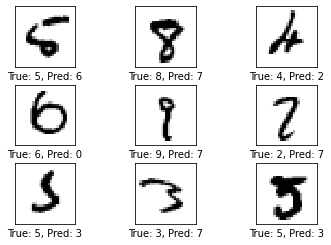

Accuracy on Test-Set: 96.7% (9669 / 10000)
Example errors:


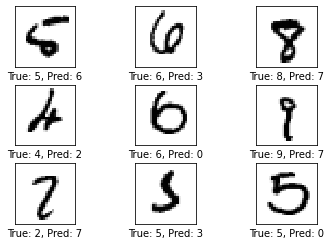

In [ ]:
for i in range(10):
  print_test_accuracy(test_acc_list[i],show_example_errors=True)

## Find the adversarial noise

Before we start optimizing the adversarial noise, we first initialize it to zero. This was already done above but it is repeated here in case you want to re-run this code with another target-class.

In [ ]:
init_noise()

Now perform optimization of the adversarial noise. This uses the adversarial optimizer instead of the normal optimizer, which means that it only optimizes the variable for the adversarial noise, while ignoring all the other variables of the neural network.

In [ ]:
optimize_f(num_iterations=600, adversary_target_cls=2,accuracy = acc_list[2],optimizer = opt_list[2],optimizer_adversary = opt_adv_list[2])

Optimization Iteration:      0, Training Accuracy:  11.0%
Optimization Iteration:    100, Training Accuracy:  99.7%
Optimization Iteration:    200, Training Accuracy:  99.7%
Optimization Iteration:    300, Training Accuracy:  99.7%
Optimization Iteration:    400, Training Accuracy:  99.0%
Optimization Iteration:    500, Training Accuracy:  99.0%
Optimization Iteration:    599, Training Accuracy:  98.7%
Time usage: 0:00:05


The adversarial noise has now been optimized and it can be shown in a plot. The red pixels show positive noise-values and the blue pixels show negative noise-values. This noise-pattern is added to every input image. The positive (red) noise-values makes the pixels darker and the negative (blue) noise-values makes the pixels brighter. Examples of this are shown below.

Noise:
- Min: -0.29783055
- Max: 0.35
- Std: 0.11622804


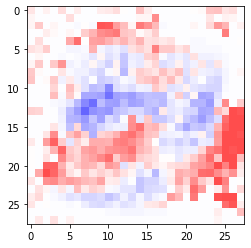

In [ ]:
plot_noise()

When this noise is added to all the images in the test-set, the result is typically a classification accuracy of 10-15% depending on the target-class that was chosen. We can also see from the confusion matrix that most images in the test-set are now classified as the desired target-class - although some of the target-classes require more adversarial noise than others.

So we have found adversarial noise that makes the neural network mis-classify almost all images in the test-set as our desired target-class.

We can also show some examples of mis-classified images with the adversarial noise. The noise is clearly visible but the digits are still easily identified by the human eye.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if sys.path[0] == '':


Accuracy on Test-Set: 11.1% (1111 / 10000)
Example errors:


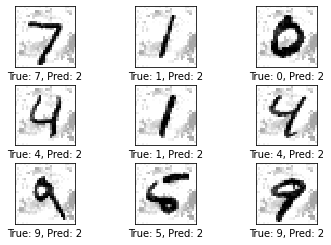

Confusion Matrix:
[[  35    0  945    0    0    0    0    0    0    0]
 [   0    0 1135    0    0    0    0    0    0    0]
 [   0    0 1032    0    0    0    0    0    0    0]
 [   0    0  995   15    0    0    0    0    0    0]
 [   0    0  981    0    1    0    0    0    0    0]
 [   0    0  885    2    0    4    0    0    1    0]
 [   0    0  938    0    0    0   20    0    0    0]
 [   0    0 1026    0    0    0    0    2    0    0]
 [   0    0  972    0    0    0    0    0    2    0]
 [   0    0 1008    0    0    0    0    0    1    0]]


In [ ]:
print_test_accuracy(y_pred_cls_2,show_example_errors=True,
                    show_confusion_matrix=True)

In [ ]:
init_noise()

## Adversarial noise for all target-classes

This is a helper-function for finding the adversarial noise for all target-classes. The function loops over all the class-numbers from 0 to 9 and runs the optimization above. The results are then stored in an array.

In [ ]:
def find_all_noise(num_iterations=600):
    # Adversarial noise for all target-classes.
    all_noise = []

    # For each target-class.
    for i in range(num_classes):
        print("Finding adversarial noise for target-class:", i)

        # Reset the adversarial noise to zero.
        init_noise()

        # Optimize the adversarial noise.
        optimize_f(num_iterations=num_iterations,
                 adversary_target_cls=i,optimizer = opt_list[i],optimizer_adversary = opt_adv_list[i],accuracy = acc_list[i])

        # Get the adversarial noise from inside the TensorFlow graph.
        noise = get_noise()

        # Append the noise to the array.
        all_noise.append(noise)

        # Print newline.
        print()
    
    return all_noise

In [ ]:
all_noise = find_all_noise(num_iterations=600)

Finding adversarial noise for target-class: 0
Optimization Iteration:      0, Training Accuracy:   9.7%
Optimization Iteration:    100, Training Accuracy:  98.7%
Optimization Iteration:    200, Training Accuracy:  99.0%
Optimization Iteration:    300, Training Accuracy:  99.3%
Optimization Iteration:    400, Training Accuracy:  98.7%
Optimization Iteration:    500, Training Accuracy:  98.3%
Optimization Iteration:    599, Training Accuracy:  98.0%
Time usage: 0:00:05

Finding adversarial noise for target-class: 1
Optimization Iteration:      0, Training Accuracy:  13.3%
Optimization Iteration:    100, Training Accuracy:  93.7%
Optimization Iteration:    200, Training Accuracy:  95.3%
Optimization Iteration:    300, Training Accuracy:  95.3%
Optimization Iteration:    400, Training Accuracy:  96.0%
Optimization Iteration:    500, Training Accuracy:  96.0%
Optimization Iteration:    599, Training Accuracy:  96.0%
Time usage: 0:00:05

Finding adversarial noise for target-class: 2
Optimiza

### Plot the adversarial noise for all target-classes

This is a helper-function for plotting a grid with the adversarial noise for all target-classes 0 to 9.

In [ ]:
def plot_all_noise(all_noise):    
    # Create figure with 10 sub-plots.
    fig, axes = plt.subplots(2, 5)
    fig.subplots_adjust(hspace=0.2, wspace=0.1)

    # For each sub-plot.
    for i, ax in enumerate(axes.flat):
        # Get the adversarial noise for the i'th target-class.
        noise = all_noise[i]
        
        # Plot the noise.
        ax.imshow(noise,
                  cmap='seismic', interpolation='nearest',
                  vmin=-1.0, vmax=1.0)

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(i)

        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

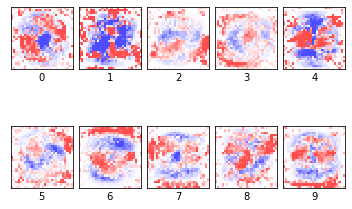

In [ ]:
plot_all_noise(all_noise)

Red pixels show positive noise values, and blue pixels show negative noise values.

In some of these noise-images you can see traces of the numbers. For example, the noise for target-class 0 shows a red circle surrounded by blue. This means that a little noise will be added to the input image in the shape of a circle, and it will dampen the other pixels. This is sufficient for most input images in the MNIST data-set to be mis-classified as a 0. Another example is the noise for 3 which also shows traces of the number 3 with red pixels. But the noise for the other classes is less obvious.

## Immunity to adversarial noise

We will now try and make the neural network immune to adversarial noise. We do this by re-training the neural network to ignore the adversarial noise. This process can be repeated a number of times.

### Helper-function to make a neural network immune to noise

This is the helper-function for making the neural network immune to adversarial noise. First it runs the optimization to find the adversarial noise. Then it runs the normal optimization to make the neural network immune to that noise.

In [ ]:
def make_immune_1(target_cls, num_iterations_adversary=600,
                num_iterations_immune=400):

    print("Target-class:", target_cls)
    print("Finding adversarial noise ...")

    # Find the adversarial noise.
    optimize_f(num_iterations=num_iterations_adversary,
             adversary_target_cls=target_cls,optimizer = opt_list[target_cls],optimizer_adversary = opt_adv_list[target_cls],accuracy = acc_list[target_cls])
    

    # Newline.
    print()
    
    # Print classification accuracy.
    print_test_accuracy(y_pred_cls = test_acc_list[target_cls],show_example_errors=False,
                        show_confusion_matrix=False)

    # Newline.
    print()

    print("Making the neural network immune to the noise ...")

    # Try and make the neural network immune to this noise.
    # Note that the adversarial noise has not been reset to zero
    # so the x_noise variable still holds the noise.
    # So we are training the neural network to ignore the noise.
    optimize_f(num_iterations=num_iterations_immune,optimizer = opt_list[target_cls],accuracy = acc_list[target_cls],optimizer_adversary =None)

    # Newline.
    print()
    
    # Print classification accuracy.
    print_test_accuracy(y_pred_cls = test_acc_list[target_cls],show_example_errors=False,
                        show_confusion_matrix=False)

In [ ]:
make_immune_1(target_cls=2)

Target-class: 2
Finding adversarial noise ...
Optimization Iteration:      0, Training Accuracy:   0.3%
Optimization Iteration:    100, Training Accuracy:  99.3%
Optimization Iteration:    200, Training Accuracy:  99.0%
Optimization Iteration:    300, Training Accuracy:  97.3%
Optimization Iteration:    400, Training Accuracy:  99.0%
Optimization Iteration:    500, Training Accuracy:  99.0%
Optimization Iteration:    599, Training Accuracy:  99.3%
Time usage: 0:00:05

Accuracy on Test-Set: 11.5% (1152 / 10000)

Making the neural network immune to the noise ...
Optimization Iteration:      0, Training Accuracy:  33.0%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if sys.path[0] == '':


Optimization Iteration:    100, Training Accuracy:  96.7%
Optimization Iteration:    200, Training Accuracy:  97.0%
Optimization Iteration:    300, Training Accuracy:  98.0%
Optimization Iteration:    399, Training Accuracy:  98.3%
Time usage: 0:00:02

Accuracy on Test-Set: 96.9% (9687 / 10000)


In [ ]:
make_immune_1(target_cls=2)

Target-class: 2
Finding adversarial noise ...
Optimization Iteration:      0, Training Accuracy:   9.0%
Optimization Iteration:    100, Training Accuracy:  90.7%
Optimization Iteration:    200, Training Accuracy:  90.7%
Optimization Iteration:    300, Training Accuracy:  94.3%
Optimization Iteration:    400, Training Accuracy:  94.3%
Optimization Iteration:    500, Training Accuracy:  92.3%
Optimization Iteration:    599, Training Accuracy:  91.7%
Time usage: 0:00:05

Accuracy on Test-Set: 16.3% (1627 / 10000)

Making the neural network immune to the noise ...
Optimization Iteration:      0, Training Accuracy:  41.3%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if sys.path[0] == '':


Optimization Iteration:    100, Training Accuracy:  96.3%
Optimization Iteration:    200, Training Accuracy:  95.7%
Optimization Iteration:    300, Training Accuracy:  97.7%
Optimization Iteration:    399, Training Accuracy:  98.3%
Time usage: 0:00:02

Accuracy on Test-Set: 96.9% (9692 / 10000)


In [ ]:
make_immune_1(target_cls=2)

Target-class: 2
Finding adversarial noise ...
Optimization Iteration:      0, Training Accuracy:   8.7%
Optimization Iteration:    100, Training Accuracy:  52.3%
Optimization Iteration:    200, Training Accuracy:  62.0%
Optimization Iteration:    300, Training Accuracy:  60.7%
Optimization Iteration:    400, Training Accuracy:  63.3%
Optimization Iteration:    500, Training Accuracy:  63.7%
Optimization Iteration:    599, Training Accuracy:  69.7%
Time usage: 0:00:05

Accuracy on Test-Set: 38.7% (3869 / 10000)

Making the neural network immune to the noise ...
Optimization Iteration:      0, Training Accuracy:  63.0%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if sys.path[0] == '':


Optimization Iteration:    100, Training Accuracy:  97.7%
Optimization Iteration:    200, Training Accuracy:  95.7%
Optimization Iteration:    300, Training Accuracy:  97.7%
Optimization Iteration:    399, Training Accuracy:  98.0%
Time usage: 0:00:02

Accuracy on Test-Set: 97.0% (9697 / 10000)


In [ ]:
make_immune_1(target_cls=2)

Target-class: 2
Finding adversarial noise ...
Optimization Iteration:      0, Training Accuracy:  12.3%
Optimization Iteration:    100, Training Accuracy:  60.0%
Optimization Iteration:    200, Training Accuracy:  70.0%
Optimization Iteration:    300, Training Accuracy:  69.0%
Optimization Iteration:    400, Training Accuracy:  66.7%
Optimization Iteration:    500, Training Accuracy:  73.7%
Optimization Iteration:    599, Training Accuracy:  73.7%
Time usage: 0:00:05

Accuracy on Test-Set: 33.1% (3306 / 10000)

Making the neural network immune to the noise ...
Optimization Iteration:      0, Training Accuracy:  63.3%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if sys.path[0] == '':


Optimization Iteration:    100, Training Accuracy:  97.7%
Optimization Iteration:    200, Training Accuracy:  98.0%
Optimization Iteration:    300, Training Accuracy:  98.3%
Optimization Iteration:    399, Training Accuracy:  99.3%
Time usage: 0:00:02

Accuracy on Test-Set: 97.0% (9703 / 10000)


In [ ]:
make_immune_1(target_cls=2)

Target-class: 2
Finding adversarial noise ...
Optimization Iteration:      0, Training Accuracy:   8.3%
Optimization Iteration:    100, Training Accuracy:  25.3%
Optimization Iteration:    200, Training Accuracy:  35.0%
Optimization Iteration:    300, Training Accuracy:  42.0%
Optimization Iteration:    400, Training Accuracy:  44.7%
Optimization Iteration:    500, Training Accuracy:  42.3%
Optimization Iteration:    599, Training Accuracy:  45.3%
Time usage: 0:00:05

Accuracy on Test-Set: 61.4% (6142 / 10000)

Making the neural network immune to the noise ...
Optimization Iteration:      0, Training Accuracy:  79.0%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if sys.path[0] == '':


Optimization Iteration:    100, Training Accuracy:  99.3%
Optimization Iteration:    200, Training Accuracy:  97.7%
Optimization Iteration:    300, Training Accuracy:  98.0%
Optimization Iteration:    399, Training Accuracy:  99.7%
Time usage: 0:00:02

Accuracy on Test-Set: 97.2% (9724 / 10000)


Now try and run it again. It is now more difficult to find adversarial noise for the target-class 3. The neural network seems to have become somewhat immune to adversarial noise.

### Make immune to noise for all target-classes

Now try and make the neural network immune to adversarial noise for all target-classes. Unfortunately this does not seem to work so well.

In [ ]:
for i in range(10):
    make_immune_1(target_cls=i)
    
    # Print newline.
    print()

Target-class: 0
Finding adversarial noise ...
Optimization Iteration:      0, Training Accuracy:   1.7%
Optimization Iteration:    100, Training Accuracy:  93.3%
Optimization Iteration:    200, Training Accuracy:  96.0%
Optimization Iteration:    300, Training Accuracy:  96.3%
Optimization Iteration:    400, Training Accuracy:  96.0%
Optimization Iteration:    500, Training Accuracy:  98.3%
Optimization Iteration:    599, Training Accuracy:  96.3%
Time usage: 0:00:05

Accuracy on Test-Set: 13.0% (1297 / 10000)

Making the neural network immune to the noise ...
Optimization Iteration:      0, Training Accuracy:  58.0%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if sys.path[0] == '':


Optimization Iteration:    100, Training Accuracy:  96.7%
Optimization Iteration:    200, Training Accuracy:  99.0%
Optimization Iteration:    300, Training Accuracy:  98.0%
Optimization Iteration:    399, Training Accuracy:  98.3%
Time usage: 0:00:02

Accuracy on Test-Set: 96.9% (9686 / 10000)

Target-class: 1
Finding adversarial noise ...
Optimization Iteration:      0, Training Accuracy:   0.0%
Optimization Iteration:    100, Training Accuracy:  88.7%
Optimization Iteration:    200, Training Accuracy:  90.3%
Optimization Iteration:    300, Training Accuracy:  91.7%
Optimization Iteration:    400, Training Accuracy:  93.0%
Optimization Iteration:    500, Training Accuracy:  96.0%
Optimization Iteration:    599, Training Accuracy:  93.3%
Time usage: 0:00:05

Accuracy on Test-Set: 17.0% (1695 / 10000)

Making the neural network immune to the noise ...
Optimization Iteration:      0, Training Accuracy:  54.0%
Optimization Iteration:    100, Training Accuracy:  96.3%
Optimization Iterati

### Make immune to all target-classes (double runs)

Now try and use double-runs to make the neural network immune to adversarial noise for all target-classes. Unfortunately this does not seem to work so well either.

Making the neural network immune to one adversarial target-class appears to cancel the immunity towards the other target-classes.

In [ ]:
for i in range(10):
    make_immune_1(target_cls=i)
    
    # Print newline.
    print()
    
    make_immune_1(target_cls=i)

    # Print newline.
    print()

Target-class: 0
Finding adversarial noise ...
Optimization Iteration:      0, Training Accuracy:   0.0%
Optimization Iteration:    100, Training Accuracy:  29.7%
Optimization Iteration:    200, Training Accuracy:  25.7%
Optimization Iteration:    300, Training Accuracy:  35.7%
Optimization Iteration:    400, Training Accuracy:  34.3%
Optimization Iteration:    500, Training Accuracy:  37.3%
Optimization Iteration:    599, Training Accuracy:  37.7%
Time usage: 0:00:05

Accuracy on Test-Set: 62.2% (6217 / 10000)

Making the neural network immune to the noise ...
Optimization Iteration:      0, Training Accuracy:  79.0%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if sys.path[0] == '':


Optimization Iteration:    100, Training Accuracy:  96.0%
Optimization Iteration:    200, Training Accuracy:  96.3%
Optimization Iteration:    300, Training Accuracy:  98.3%
Optimization Iteration:    399, Training Accuracy:  96.7%
Time usage: 0:00:02

Accuracy on Test-Set: 97.2% (9717 / 10000)

Target-class: 0
Finding adversarial noise ...
Optimization Iteration:      0, Training Accuracy:   9.7%
Optimization Iteration:    100, Training Accuracy:  18.7%
Optimization Iteration:    200, Training Accuracy:  22.3%
Optimization Iteration:    300, Training Accuracy:  16.0%
Optimization Iteration:    400, Training Accuracy:  20.0%
Optimization Iteration:    500, Training Accuracy:  25.3%
Optimization Iteration:    599, Training Accuracy:  23.0%
Time usage: 0:00:05

Accuracy on Test-Set: 82.3% (8227 / 10000)

Making the neural network immune to the noise ...
Optimization Iteration:      0, Training Accuracy:  88.3%
Optimization Iteration:    100, Training Accuracy:  99.0%
Optimization Iterati

In [ ]:
for i in range(10):
    make_immune_1(target_cls=i)
    
    # Print newline.
    print()
    
    make_immune_1(target_cls=i)

    # Print newline.
    print()

Target-class: 0
Finding adversarial noise ...
Optimization Iteration:      0, Training Accuracy:   0.0%
Optimization Iteration:    100, Training Accuracy:  10.7%
Optimization Iteration:    200, Training Accuracy:   9.7%
Optimization Iteration:    300, Training Accuracy:  14.0%
Optimization Iteration:    400, Training Accuracy:  11.0%
Optimization Iteration:    500, Training Accuracy:  14.3%
Optimization Iteration:    599, Training Accuracy:  11.7%
Time usage: 0:00:05

Accuracy on Test-Set: 82.6% (8256 / 10000)

Making the neural network immune to the noise ...
Optimization Iteration:      0, Training Accuracy:  90.3%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if sys.path[0] == '':


Optimization Iteration:    100, Training Accuracy:  99.0%
Optimization Iteration:    200, Training Accuracy:  99.0%
Optimization Iteration:    300, Training Accuracy:  98.7%
Optimization Iteration:    399, Training Accuracy:  98.3%
Time usage: 0:00:02

Accuracy on Test-Set: 97.2% (9715 / 10000)

Target-class: 0
Finding adversarial noise ...
Optimization Iteration:      0, Training Accuracy:   9.7%
Optimization Iteration:    100, Training Accuracy:  10.3%
Optimization Iteration:    200, Training Accuracy:  14.3%
Optimization Iteration:    300, Training Accuracy:  12.7%
Optimization Iteration:    400, Training Accuracy:  12.3%
Optimization Iteration:    500, Training Accuracy:  23.0%
Optimization Iteration:    599, Training Accuracy:  17.0%
Time usage: 0:00:05

Accuracy on Test-Set: 79.3% (7927 / 10000)

Making the neural network immune to the noise ...
Optimization Iteration:      0, Training Accuracy:  87.7%
Optimization Iteration:    100, Training Accuracy:  99.3%
Optimization Iterati

In [ ]:
for i in range(10):
    make_immune_1(target_cls=i)
    
    # Print newline.
    print()
    
    make_immune_1(target_cls=i)

    # Print newline.
    print()

Target-class: 0
Finding adversarial noise ...
Optimization Iteration:      0, Training Accuracy:   0.7%
Optimization Iteration:    100, Training Accuracy:  11.3%
Optimization Iteration:    200, Training Accuracy:  12.0%
Optimization Iteration:    300, Training Accuracy:   9.3%
Optimization Iteration:    400, Training Accuracy:   9.7%
Optimization Iteration:    500, Training Accuracy:  12.7%
Optimization Iteration:    599, Training Accuracy:   9.7%
Time usage: 0:00:05

Accuracy on Test-Set: 82.8% (8277 / 10000)

Making the neural network immune to the noise ...
Optimization Iteration:      0, Training Accuracy:  90.7%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if sys.path[0] == '':


Optimization Iteration:    100, Training Accuracy:  98.7%
Optimization Iteration:    200, Training Accuracy:  99.7%
Optimization Iteration:    300, Training Accuracy:  98.7%
Optimization Iteration:    399, Training Accuracy: 100.0%
Time usage: 0:00:02

Accuracy on Test-Set: 97.4% (9741 / 10000)

Target-class: 0
Finding adversarial noise ...
Optimization Iteration:      0, Training Accuracy:   7.7%
Optimization Iteration:    100, Training Accuracy:   7.0%
Optimization Iteration:    200, Training Accuracy:  11.0%
Optimization Iteration:    300, Training Accuracy:  13.0%
Optimization Iteration:    400, Training Accuracy:  13.3%
Optimization Iteration:    500, Training Accuracy:  15.7%
Optimization Iteration:    599, Training Accuracy:  15.7%
Time usage: 0:00:05

Accuracy on Test-Set: 87.2% (8718 / 10000)

Making the neural network immune to the noise ...
Optimization Iteration:      0, Training Accuracy:  93.3%
Optimization Iteration:    100, Training Accuracy: 100.0%
Optimization Iterati

Function to predict using first neural network not trained against noise and then a second neural network trained against noise for each particular target class.

In [ ]:


def multi():
    test_batch_size = 1
    #end index in test set of 10000
    num_test = 2934

    # Allocate an array for the predicted classes which
    # will be calculated in batches and filled into this array.
    cls_pred = np.zeros(shape=num_test, dtype=np.int)

    # Now calculate the predicted classes for the batches.
    # We will just iterate through all the batches.
    # There might be a more clever and Pythonic way of doing this.

    # The starting index
    i = 2930

    while i < num_test:
        # The ending index for the next batch is denoted j.
        j = min(i + test_batch_size, num_test)

        # Get the images from the test-set between index i and j.
        images = data.x_test[i:j, :]
        cls_true = data.y_test_cls[i:j]

        fig, axes = plt.subplots(1, 1)
        fig.subplots_adjust(hspace=0.3, wspace=0.3)
         
       
        # Get the i'th image and reshape the array.
        image = images.reshape(img_shape)
        print('for', i ,'th image in test set')
        noise = get_noise()
        image = image+ noise
        # Plot image.
        axes.imshow(image,
                  cmap='gray')

        # Show true and predicted classes.
        xlabel = "True: {0}".format(cls_true)
       
        # Show the classes as the label on the x-axis.
        axes.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        axes.set_xticks([])
        axes.set_yticks([])
    
   
        plt.show()
        
        # Ensure the noisy pixel-values are between 0 and 1.


        # Get the associated labels.
        labels = data.y_test[i:j, :]
        print()

        # Create a feed-dict with these images and labels.
        feed_dict = {x: images,
                     y_true: labels}

        # Calculate the predicted class using TensorFlow.
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)
        print('Predicted by first tier ANN:', cls_pred[i:j])
        print()
        #Choose second network based on prediction from first network and do prediction again
        if cls_pred[i:j] == 0:
          cls_pred[i:j] = session.run(y_pred_cls_0, feed_dict=feed_dict)
          print('Predicted by second tier ANN:', cls_pred[i:j])
        elif cls_pred[i:j]== 1:
          cls_pred[i:j] = session.run(y_pred_cls_1, feed_dict=feed_dict)
          print('Predicted by second tier ANN:', cls_pred[i:j])
        elif cls_pred[i:j]== 2:
          cls_pred[i:j] = session.run(y_pred_cls_2, feed_dict=feed_dict)
          print('Predicted by second tier ANN:', cls_pred[i:j])
        elif cls_pred[i:j]== 3:
          cls_pred[i:j] = session.run(y_pred_cls_3, feed_dict=feed_dict)
          print('Predicted by second tier ANN:', cls_pred[i:j])
        elif cls_pred[i:j]== 4:
          cls_pred[i:j] = session.run(y_pred_cls_4, feed_dict=feed_dict)
          print('Predicted by second tier ANN:', cls_pred[i:j])
        elif cls_pred[i:j]== 5:
          cls_pred[i:j] = session.run(y_pred_cls_5, feed_dict=feed_dict)
          print('Predicted by second tier ANN:', cls_pred[i:j])
        elif cls_pred[i:j]== 6:
          cls_pred[i:j] = session.run(y_pred_cls_6, feed_dict=feed_dict)
          print('Predicted by second tier ANN:', cls_pred[i:j])
        elif cls_pred[i:j]== 7:
          cls_pred[i:j] = session.run(y_pred_cls_7, feed_dict=feed_dict)
          print('Predicted by second tier ANN:', cls_pred[i:j])
        elif cls_pred[i:j]== 8:
          cls_pred[i:j] = session.run(y_pred_cls_8, feed_dict=feed_dict)
          print('Predicted by second tier ANN:', cls_pred[i:j])
        elif cls_pred[i:j]== 9:
          cls_pred[i:j] = session.run(y_pred_cls_9, feed_dict=feed_dict)
          print('Predicted by second tier ANN:', cls_pred[i:j])
        print()

        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j



Calling the adversarial noise for any class and then calling the above function to test the robustness of the second tier neural networks.

Target-class: 2
Finding adversarial noise ...
Optimization Iteration:      0, Training Accuracy:  10.7%
Optimization Iteration:    100, Training Accuracy:  11.7%
Optimization Iteration:    200, Training Accuracy:   9.7%
Optimization Iteration:    300, Training Accuracy:  30.0%
Optimization Iteration:    400, Training Accuracy:  40.3%
Optimization Iteration:    500, Training Accuracy:  44.0%
Optimization Iteration:    599, Training Accuracy:  47.3%
Time usage: 0:00:05

Accuracy on Test-Set: 56.9% (5692 / 10000)

Making the neural network immune to the noise ...
Optimization Iteration:      0, Training Accuracy:  84.0%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if sys.path[0] == '':


Optimization Iteration:    100, Training Accuracy:  99.7%
Optimization Iteration:    200, Training Accuracy:  99.0%
Optimization Iteration:    300, Training Accuracy:  99.3%
Optimization Iteration:    399, Training Accuracy:  99.3%
Time usage: 0:00:02

Accuracy on Test-Set: 97.5% (9754 / 10000)
for 2930 th image in test set


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # Remove the CWD from sys.path while we load stuff.


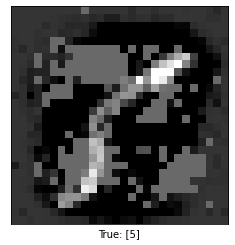


Predicted by first tier ANN: [2]

Predicted by second tier ANN: [7]

for 2931 th image in test set


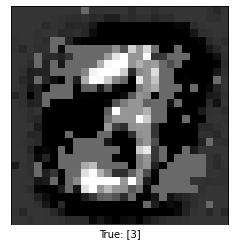


Predicted by first tier ANN: [2]

Predicted by second tier ANN: [3]

for 2932 th image in test set


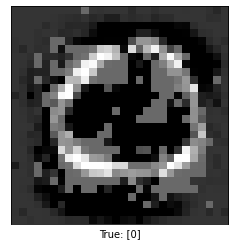


Predicted by first tier ANN: [2]

Predicted by second tier ANN: [0]

for 2933 th image in test set


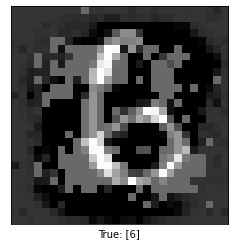


Predicted by first tier ANN: [2]

Predicted by second tier ANN: [6]



In [ ]:
make_immune_1(target_cls=2)
multi()

Interestingly, the neural network now has a higher classification accuracy on noisy images than we had on clean images before all these optimizations.

## Close TensorFlow Session

We are now done using TensorFlow, so we close the session to release its resources.

In [ ]:
# This has been commented out in case you want to modify and experiment
# with the Notebook without having to restart it.
# session.close()